In [2]:
# путь до папки scripts с необходимыми скриптами,
# в папке preprocessing необходимые блоки, которые 
# используются для построения pipeline

import sys
PATH_TO_PREPROCESSING = "."
sys.path.append(PATH_TO_PREPROCESSING)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE

import preprocessing as prep

In [3]:
paths_to_nested = ["/home/drozdovmk/Projects/ZB/data/data_markup/cesis_nabor_0",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/demostend_0",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/samara_wind",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/Kashira_13may"]

old_paths = ["/home/drozdovmk/Projects/ZB/data/data_markup/hdf5_adaptive"]

labels_to_delete = ["hit_series", "unknown"]
dict_to_rename = {"hit_g": "hit", "hit_z": "hit"}
balanced_classes = False


dataset = prep.ParseToPandas(paths_to_nested=paths_to_nested,
                             old_paths=old_paths,
                             labels_to_delete=labels_to_delete,
                             dict_to_rename=dict_to_rename,
                             balanced_classes=balanced_classes)


Found unknown label in zone 455 
date: 23/12/2024 14:57:52
Found unknown label in zone 737 
date: 24/12/2024 05:47:32
Found unknown label in zone 737 
date: 24/12/2024 05:51:41
Found unknown label in zone 737 
date: 24/12/2024 14:41:29
Found unknown label in zone 737 
date: 24/12/2024 14:41:39
Found unknown label in zone 737 
date: 24/12/2024 06:08:46
Found unknown label in zone 737 
date: 24/12/2024 16:17:34
Found unknown label in zone 737 
date: 24/12/2024 16:17:49
Found unknown label in zone 775 
date: 13/05/2025 11:39:49
Found unknown label in zone 775 
date: 13/05/2025 12:40:28
Found unknown label in zone 775 
date: 13/05/2025 12:40:34
Found unknown label in zone 775 
date: 13/05/2025 12:40:40
Found unknown label in zone 775 
date: 13/05/2025 12:40:52
Found unknown label in zone 610 
date: 13/05/2025 05:57:58
Found unknown label in zone 610 
date: 13/05/2025 14:04:13
Found unknown label in zone 610 
date: 13/05/2025 14:47:01
Found unknown label in zone 610 
date: 13/05/2025 06:05:

In [4]:
data_hdf5 = dataset.data_hdf5
labels = dataset.label_hdf5
print("Статистика по классам:")
print(labels.value_counts())

Статистика по классам:
wind       956
hit        558
saw        236
perelaz    208
Name: count, dtype: int64


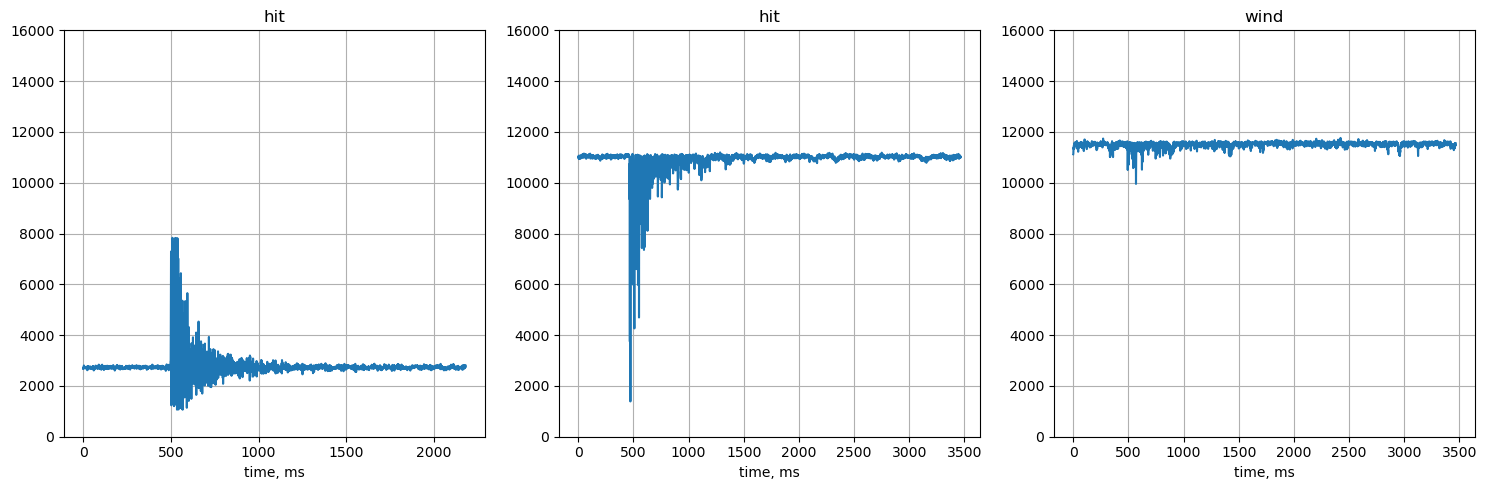

In [5]:
# Визуализация нескольких объектов
number_of_samples = 3
random_indexes = np.random.choice(data_hdf5["id"].unique(), size=number_of_samples)
fig, ax = plt.subplots(1, number_of_samples, figsize=(5*number_of_samples,5))

for i, ind in enumerate(random_indexes):
    
    ax[i].plot(data_hdf5[data_hdf5["id"] == ind].time,
               data_hdf5[data_hdf5["id"] == ind].signal_raw)
    ax[i].set_ylim([0, 16000])
    ax[i].set_title(labels[ind])
    ax[i].set_xlabel("time, ms")
    ax[i].grid()
plt.tight_layout()

In [6]:

timeTransformer = prep.TimePreprocessing(std_window = 32,
                                         mean_window = 128,
                                         normilize=True)
freqTransformer = prep.FreqPreprocessing(n_bins = 100,
                                         fs = 1000)

data_time = timeTransformer.transform(data_hdf5)
data_freq = freqTransformer.transform(data_hdf5)

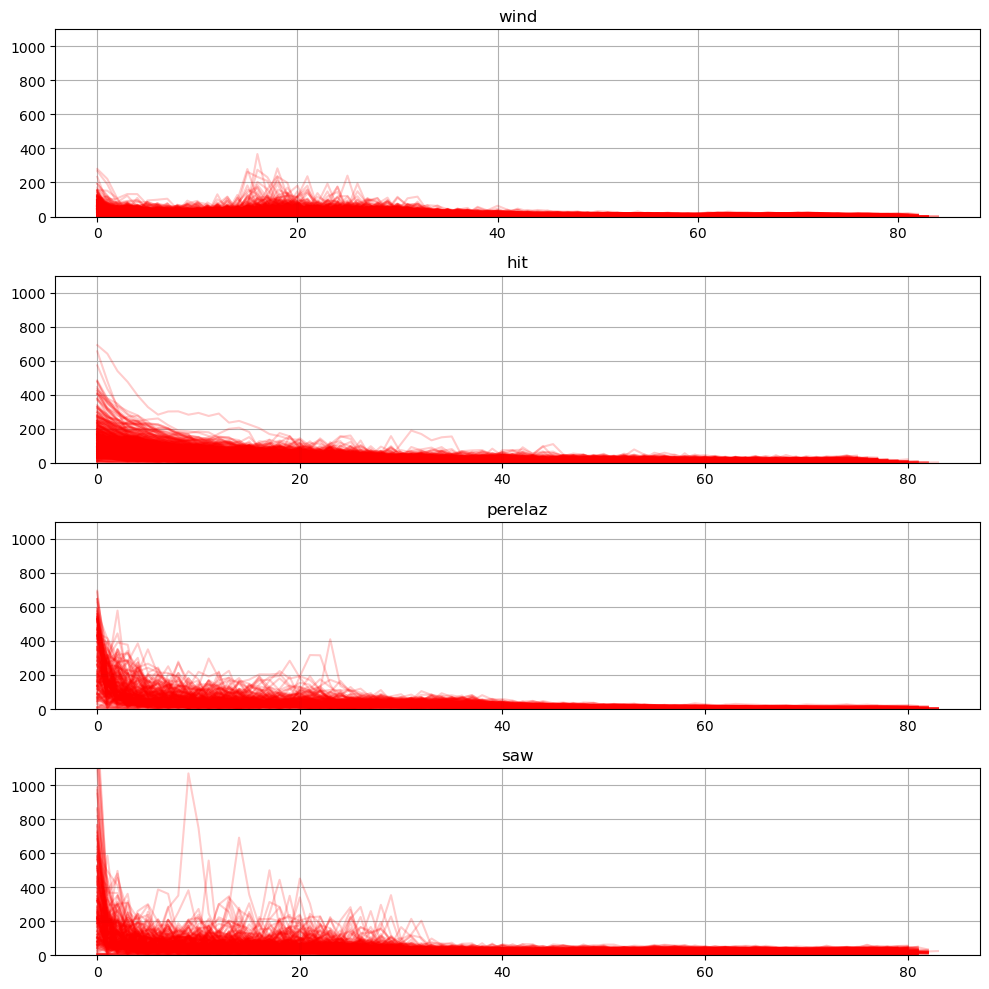

In [7]:
# визуализация спектров по классам
classnames = dataset.label_to_id.keys()
fig, ax = plt.subplots(len(classnames), 1, figsize = (10,10))
for key, value in dataset.label_to_id.items():
    ax[value].set_title(key)
    ax[value].set_ylim([0, 1100])
    ax[value].grid()
idxs = data_freq["id"].unique()
for i in idxs:
    idx_classname = dataset.label_to_id[labels[i]]
    ax[idx_classname].plot(data_freq[data_freq["id"] == i]["signal_binned_fft"].values, alpha=0.2, c="r")
    # ax[idx_classname, 1].plot(data_time[data_filtered["id"] == i]["signal_mean"].values, alpha=0.02, c="r")
plt.tight_layout()

In [8]:
# Здесь видно, что pipeline sklearn строится из некоторых блоков, описанных в prep (preprocessing)
# в описанном ниже pipeline пока нет финальной модели. Поэтому можно экспериментировать с выходом
# preprocessing блоков, контролировать что будет поступать на финальную модель, проводить анализ признаков (EDA)
# и так далее


time_feature_extractor = Pipeline([
    ("TimePreprocessing", prep.TimePreprocessing(std_window = 32,
                                                 mean_window = 128,
                                                 normilize=True)),
    ("CustomFeatureAugmenter", prep.CustomFeatureAugmenter(column_id='id',
                                                      column_sort='time',
                                                      kind_to_fc_parameters = prep.MyCustomFeatures.time_features,
                                                      disable_progressbar=True,
                                                      n_jobs=10)),
    ])

freq_feature_extractor = Pipeline([
    ("FreqPreprocessing", prep.FreqPreprocessing(n_bins=70,
                                                 fs = 1000)),
    ("CustomFeatureAugmenter", prep.CustomFeatureAugmenter(column_id='id',
                                                           column_sort='freq_num',
                                                           default_fc_parameters = prep.MyCustomFeatures.freq_features,
                                                           disable_progressbar=True,
                                                           n_jobs = 10))
    ])

feature_union = Pipeline([
    ("FeatureUnion", FeatureUnion(transformer_list=[("timeExtractor", time_feature_extractor),
                                                    ("freqExtractor", freq_feature_extractor)])),
    ("ColumnSorter", prep.ColumnSorter())
    ])
feature_union.set_output(transform="pandas")


Pipeline(steps=[('FeatureUnion',
                 FeatureUnion(transformer_list=[('timeExtractor',
                                                 Pipeline(steps=[('TimePreprocessing',
                                                                  TimePreprocessing(mean_window=128,
                                                                                    normilize=True,
                                                                                    std_window=32)),
                                                                 ('CustomFeatureAugmenter',
                                                                  CustomFeatureAugmenter(column_id='id',
                                                                                         column_sort='time',
                                                                                         disable_progressbar=True,
                                                                                         kind_to_fc_parameters={'signal_mean': {'absolute_sum_of_chang...
                                                                                                                                      'ql': 0.0}],
                                                                                                                'energy_ratio_by_chunks': [{'num_segments': 10,
                                                                                                                                            'segment_focus': 8},
                                                                                                                                           {'num_segments': 10,
                                                                                                                                            'segment_focus': 9}],
                                                                                                                'index_mass_quantile': [{'q': 0.1}],
                                                                                                                'mean_change': None,
                                                                                                                'quantile': [{'q': 0.2},
                                                                                                                             {'q': 0.3}],
                                                                                                                'sum_values': None,
                                                                                                                'time_reversal_asymmetry_statistic': [{'lag': 2},
                                                                                                                                                      {'lag': 3}],
                                                                                                                'variance': None},
                                                                                         disable_progressbar=True))]))])),
                ('ColumnSorter', ColumnSorter())])

In [9]:
features = feature_union.transform(data_hdf5)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

In [96]:
# baseline with default params
model =RandomForestClassifier()  
model.fit(X_train, y_train)

test_pred_proba = model.predict_proba(X_test)
test_preds = model.predict(X_test)

print(classification_report(y_test, test_preds))


              precision    recall  f1-score   support

         hit       0.95      0.96      0.95       139
     perelaz       0.91      0.94      0.92        51
         saw       0.98      0.95      0.97        60
        wind       0.96      0.96      0.96       240

    accuracy                           0.96       490
   macro avg       0.95      0.95      0.95       490
weighted avg       0.96      0.96      0.96       490



In [1]:
# улучшение baseline
# подбор гиперпараметров при помощи optuna  

# import optuna
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 200),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
#         "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#         "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
#         "random_state": 42
#     }
#     clf = RandomForestClassifier(**params)
#     # Оценка с помощью кросс-валидации
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=cv, scoring="f1_micro").mean()
#     return score
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)

# print("Лучшие параметры:", study.best_params)
# print("Лучшая точность:", study.best_value)

In [72]:
wrong_idxs = y_test[(test_preds != y_test)].index

In [99]:
# best_params = study.best_params # when use optuna

best_params = {'n_estimators': 100,
               'max_depth': 10,
               'min_samples_split': 5,
               'min_samples_leaf': 3,
               'max_features': 'log2',
               'bootstrap': True,
               "class_weight": "balanced_subsample"}
# best_params = model.get_params()

In [100]:
clf_best = RandomForestClassifier(**best_params)


clf_best.fit(X_train, y_train)
# clf_best.fit(X_train, y_train)
train_pred = clf_best.predict(X_train)
print(classification_report(y_train, train_pred))


              precision    recall  f1-score   support

         hit       0.99      1.00      0.99       419
     perelaz       0.98      0.97      0.97       157
         saw       0.99      1.00      0.99       176
        wind       1.00      0.99      0.99       716

    accuracy                           0.99      1468
   macro avg       0.99      0.99      0.99      1468
weighted avg       0.99      0.99      0.99      1468



In [101]:
test_pred = clf_best.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         hit       0.94      0.96      0.95       139
     perelaz       0.89      0.92      0.90        51
         saw       0.98      0.97      0.97        60
        wind       0.96      0.95      0.96       240

    accuracy                           0.95       490
   macro avg       0.94      0.95      0.95       490
weighted avg       0.95      0.95      0.95       490



In [85]:

# обучаем м сохраняем итоговую модель

final_pipeline = Pipeline([("feature_extractor", feature_union),
                           ("classifier", clf_best)])
final_pipeline.set_output(transform="pandas")

Pipeline(steps=[('feature_extractor',
                 Pipeline(steps=[('FeatureUnion',
                                  FeatureUnion(transformer_list=[('timeExtractor',
                                                                  Pipeline(steps=[('TimePreprocessing',
                                                                                   TimePreprocessing(mean_window=128,
                                                                                                     normilize=True,
                                                                                                     std_window=32)),
                                                                                  ('CustomFeatureAugmenter',
                                                                                   CustomFeatureAugmenter(column_id='id',
                                                                                                          column_sort='time',
                                                                                                          disable_progressbar=True,
                                                                                                          kind_to_fc_parameters={...
                                                                                                                                 'mean_change': None,
                                                                                                                                 'quantile': [{'q': 0.2},
                                                                                                                                              {'q': 0.3}],
                                                                                                                                 'sum_values': None,
                                                                                                                                 'time_reversal_asymmetry_statistic': [{'lag': 2},
                                                                                                                                                                       {'lag': 3}],
                                                                                                                                 'variance': None},
                                                                                                          disable_progressbar=True))]))])),
                                 ('ColumnSorter', ColumnSorter())])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, max_features='log2',
                                        min_samples_leaf=3,
                                        min_samples_split=5))])

In [29]:
final_pipeline.fit(data_hdf5, labels)

Pipeline(steps=[('feature_extractor',
                 Pipeline(steps=[('FeatureUnion',
                                  FeatureUnion(transformer_list=[('timeExtractor',
                                                                  Pipeline(steps=[('TimePreprocessing',
                                                                                   TimePreprocessing(mean_window=128,
                                                                                                     normilize=True,
                                                                                                     std_window=32)),
                                                                                  ('CustomFeatureAugmenter',
                                                                                   CustomFeatureAugmenter(column_id='id',
                                                                                                          column_sort='time',
                                                                                                          disable_progressbar=True,
                                                                                                          kind_to_fc_parameters={...
                                                                                                                                 'index_mass_quantile': [{'q': 0.1}],
                                                                                                                                 'mean_change': None,
                                                                                                                                 'quantile': [{'q': 0.2},
                                                                                                                                              {'q': 0.3}],
                                                                                                                                 'sum_values': None,
                                                                                                                                 'time_reversal_asymmetry_statistic': [{'lag': 2},
                                                                                                                                                                       {'lag': 3}],
                                                                                                                                 'variance': None},
                                                                                                          disable_progressbar=True))]))])),
                                 ('ColumnSorter', ColumnSorter())])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', min_samples_leaf=5,
                                        min_samples_split=5))])

In [30]:
import joblib

joblib.dump(final_pipeline, "pipeline_v6.pkl")

['pipeline_v6.pkl']